In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant

In [7]:
def compute_return(y, r_type="log", h=1):
    if r_type == "log":
        ret = (np.log(y) - np.log(y.shift(h))) * 100
    else:
        ret = ((y - y.shift(h)) / y.shift(h)) * 100
    return ret


In [8]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

In [9]:
hist = msft.history(period="max")

In [11]:
for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"], h=i+1)


In [12]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
Date,,,,,,,,,,,,
2023-10-30 00:00:00+01:00,14770.950195,14798.000000,14678.730469,14716.540039,76179000,0.0,0.0,0.198136,-0.098546,-1.186419,-1.104199,-0.570378
2023-10-31 00:00:00+01:00,14741.440430,14829.620117,14722.379883,14810.339844,75370200,0.0,0.0,0.635354,0.833490,0.536808,-0.551065,-0.468845
2023-11-01 00:00:00+01:00,14851.959961,14949.580078,14786.320312,14923.269531,63588700,0.0,0.0,0.759613,1.394967,1.593103,1.296421,0.208549
2023-11-02 00:00:00+01:00,15033.650391,15202.429688,15028.030273,15143.599609,89446500,0.0,0.0,1.465627,2.225240,2.860594,3.058730,2.762048
2023-11-03 00:00:00+01:00,15203.799805,15269.500000,15149.719727,15189.250000,93603800,0.0,0.0,0.300997,1.766623,2.526237,3.161591,3.359727


In [13]:
# Create lagged returns as independent variables
for i in range(1, 6):
    hist[f'lag_ret{i}'] = hist['Close'].shift(i)

# Remove rows with NaN values that result from lagging
hist.dropna(inplace=True)

# Quantile levels
tau = [.025, .25, .5, .75, .975]

In [14]:
pred_quantile_regression = np.zeros((5, 5))

In [19]:
# Perform quantile regression for each horizon and quantile
for i in range(5):
    ret_str = f"ret{i+1}"
    y = hist[ret_str]  # Dependent variable
    X = hist[[f'lag_ret{j}' for j in range(1, 6)]]  # Independent variables
    X = add_constant(X)  # Adds a constant term to the predictors

    for j, q in enumerate(tau):
        # Fit the model for the q-th quantile
        mod = smf.quantreg(f'{ret_str} ~ lag_ret1 + lag_ret2 + lag_ret3 + lag_ret4 + lag_ret5', hist)
        res = mod.fit(q=q)
        
        # Predict the quantile for the last observation
        pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]

/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_53159/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]
/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_53159/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]
/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_53159/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

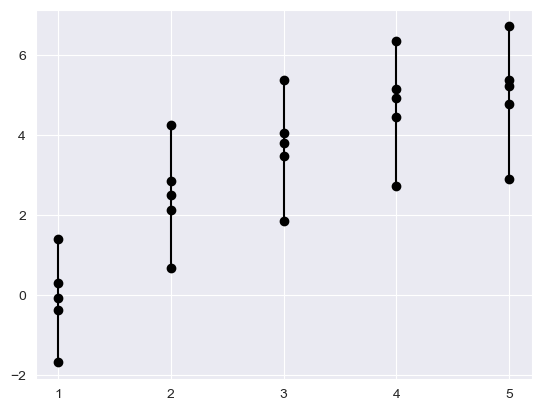

In [21]:
x = np.arange(5)+1
_ = plt.plot(x,pred_quantile_regression, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_quantile_regression[:,0], pred_quantile_regression[:,-1]),c='black')

In [22]:
df_sub = pd.DataFrame({
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1, 2, 5, 6, 7)],
    "q0.025": pred_quantile_regression[:, 0],
    "q0.25": pred_quantile_regression[:, 1],
    "q0.5": pred_quantile_regression[:, 2],
    "q0.75": pred_quantile_regression[:, 3],
    "q0.975": pred_quantile_regression[:, 4]
})

In [23]:
from datetime import datetime
date_str = datetime.today().strftime('%Y%m%d')

In [25]:
#need to change this
PATH = "./"

df_sub.to_csv(PATH+"/"+date_str+"DAX_Quantile_Regression.csv")